# 4.1 타이타닉의 생존자 가려내기
#### 피처 영향력(계수) 그래프 알아보기

### 학습 목표
- 분류분석의 개념/평가기준
- 피치 엔지니어링으로 더 나은 분석
- 감성분류

## Step1. 탐색: 타이타닉 데이터 살펴보기

- pclass : Passenger Class 승객등급
- survived : 생존여부
- name/sex/age : 이름/성별/나이
- sibsp : 동승 형제, 배우자 수
- parch : 동승 부모, 자녀 수
- ticket : 티켓번호
- fare : 지불 요금
- cabin : 선실 이름
- empbarked : 승선항
- body : 사망자 확인번호
- home.dest : 고향/목적지

### < 타이타닉 데이터셋의 기본 정보 구하기>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df_train = pd.read_csv("data/titanic_train.csv")
df_test=pd.read_csv("data/titanic_test.csv")
df_train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [2]:
print(df_train.info())
print("==================================================")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     393 non-null    int64  
 1

### < 불필요한 피처 제거하기>
####  지금 당장 분석에 활용할 수 없는 피처 : name, cabin
####  큰 의미를 가지고 있지 않은 피처 : ticket, home.dest, body 

In [3]:
# 데이터셋에서 name, ticket, body, cabin, home.dest 피처를 제거합니다.
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

#### 각 피처가 분류 분석에 미치는 영향
#### 생존자와 비생존자 그룹으로 나누어서 피처간 차이를 탐색하여 분석
#### survived를 그룹으로 하여 pclass의 그룹별 분포를 출력

### < 탐색적 데이터 분석하기>

0    563
1    353
Name: survived, dtype: int64


<AxesSubplot:>

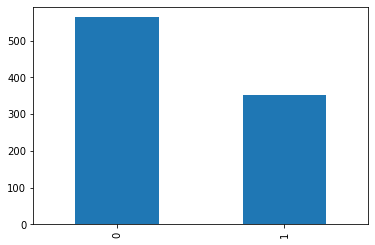

In [4]:
print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()

In [5]:
# survived 피처를 기준으로 그룹을 나누어 그룹별 pclass 피처의 분포를 살펴봅니다.
print(df_train['pclass'].value_counts())

3    498
1    230
2    188
Name: pclass, dtype: int64


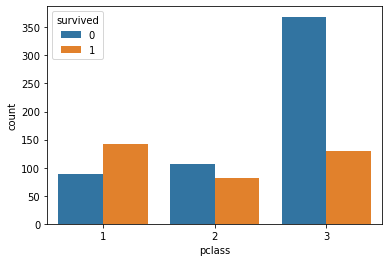

In [8]:
ax=sns.countplot(x='pclass', hue='survived', data=df_train)

#### age, sibsp 같은 수치형 피처들에 대한 탐색을 진행
#### 자동화 함수 valid_featires()를 작성
- 두 그룹간 분포를 비교하는 그래프 출력
- 두 그룹의 표준편차 출력
- 두 그룹 간의 T-test 검정을 실시하여 출력
- 두 그룹 각각에 Shapiro-wilk 검정을 실시하여 출력
 - Shapiro-wilk : 주어진 데이터가 얼마나 정규성을 따르는지, 정규분포에 가까운지를 측정

### <변수 탐색작업 자동화하기>

In [12]:
from scipy import stats

# 두 집단의 피처를 비교해주며 탐색작업을 자동화하는 함수를 정의합니다.
def valid_features(df, col_name, distribution_check=True):
    # 두 집단 (survived=1, survived=0)의 분포 그래프를 출력
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)
    
    # 두 집단 (survivedd=1, survived=0)의 표준 편차를 각각 출력
    titanic_survived=df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("Data std is", '%.2f' % np.std(titanic_survived_static))
    titanic_n_survived=df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("Data std is", '%.2f' % np.std(titanic_n_survived_static))
    
    # T-test로 두 집단의 평균 차이를 검정합니다.
    tTestResult = stats.ttest_ind(titanic_survived[col_name],titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f" % tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk 검정 : 분포의 정규성 정도를 검증합니다.
        print("The w-statistic and p-value in Survived %.3f and %.3f" % stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f" % stats.shapiro(titanic_n_survived[col_name]))        

Data std is 14.22
Data std is 13.71
The t-statistic and p-value assuming equal variances is -0.546 and 0.585
The t-statistic and p-value not assuming equal variances is -0.543 and 0.587
The w-statistic and p-value in Survived 0.982 and 0.001
The w-statistic and p-value in Non-Survived 0.968 and 0.000
Data std is 0.64
Data std is 1.34
The t-statistic and p-value assuming equal variances is -2.118 and 0.034
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015


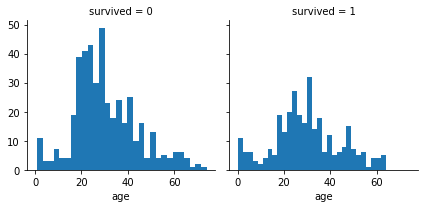

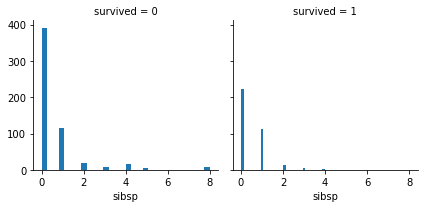

In [13]:
valid_features(df_train[df_train['age']>0], 'age', distribution_check=True)
valid_features(df_train, 'sibsp', distribution_check=False)

Data std is 0.64
Data std is 1.34
The t-statistic and p-value assuming equal variances is -2.118 and 0.034
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015
The w-statistic and p-value in Survived 0.656 and 0.000
The w-statistic and p-value in Non-Survived 0.492 and 0.000


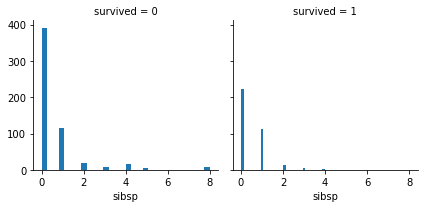

In [14]:
valid_features(df_train, 'sibsp', distribution_check=True)

#### 분석결과
- age 피처는 두 그룹 간에 평균 차이가 없기 때문에 영향력이 낮다
- sibsp 피처에서는 평균 차이가 어느정도 존재한다 ~> 영향력이 있다

### <미니 퀴즈>
#### parch,fare, sex, embarked 피처에 대한 생존자/비생존자의 차이 탐색하기

Data std is 0.74
Data std is 0.89
The t-statistic and p-value assuming equal variances is 1.865 and 0.063
The t-statistic and p-value not assuming equal variances is 1.942 and 0.052
Data std is 60.68
Data std is 33.65
The t-statistic and p-value assuming equal variances is 7.523 and 0.000
The t-statistic and p-value not assuming equal variances is 6.657 and 0.000


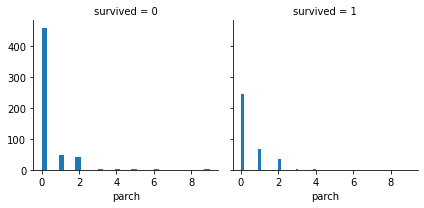

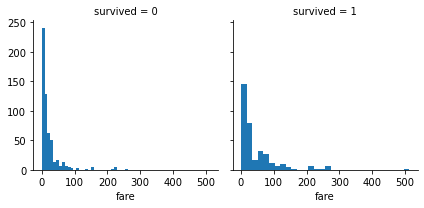

In [20]:
# 수치형 피처 : valid_features로 탐색
valid_features(df_train,'parch',distribution_check=False)
valid_features(df_train,'fare',distribution_check=False)

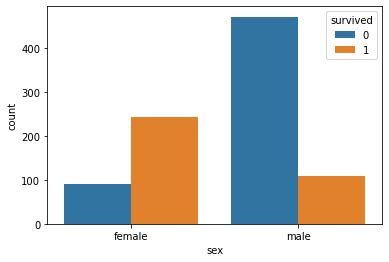

In [25]:
# 탐색적데이터 분석하기(선택형) : sns.countplot으로 분석
ax=sns.countplot(x='sex', hue='survived', data=df_train)

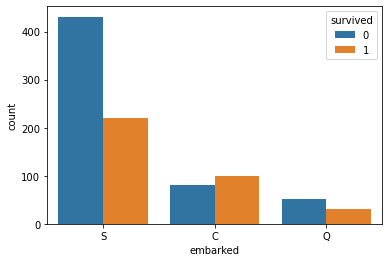

In [26]:
ax=sns.countplot(x='embarked', hue='survived', data=df_train)

### 탐색한 피처의 영향력
- 영향력上: pclass fare sex
- 영향력中: slibsp, parch
- 영향력下: age

## Step2. 분류 : 생존자 분류 모델 만들기

### 1. 로지스텍 회귀모델
#### 기존 회귀 분석의 예측값 Y를 0~1 사이의 값으로 제한하여 0.5보다 크면 1, 0.5보다 작으면 0으로 분류하는 방법
#### (1) 결측값 처리
- 결측이 존재하는 데이터 샂게
- 평균값/중앙값/최빈값 등 임의의 수치로 채워넣는 방법

#### (2) 원-핫 인코딩으로 범주형 변수를 변환
 #####  1) train데이터와 test데이터를 합친다.
 #####  2) 원-핫 인코딩 적용한다.
 #####  3) train 데이터와 test데이터를 다시 분리한다

### <분류 모델을 위해 전처리 하기>

In [29]:
#age의 결측값을 평균값으로 대체
replace_mean=df_train[df_train['age']>0]['age'].mean()
df_train['age']=df_train['age'].fillna(replace_mean)
df_test['age']=df_test['age'].fillna(replace_mean)

#embark : 2개의 결측값을 최빈값으로 대체
embarked_mode=df_train['embarked'].value_counts().index[0]
df_train['embarked']=df_train['embarked'].fillna(embarked_mode)
df_test['embarked']=df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩을 위한 통합 데이터 프레임을 생성
whole_df=df_train.append(df_test)
train_idx_num=len(df_train)

# pandas 패키지를 이용한 원-핫 인코딩을 수행
whole_df_encoded=pd.get_dummies(whole_df)
df_train=whole_df_encoded[:train_idx_num]
df_test=whole_df_encoded[train_idx_num:]
df_train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


### 분류 모델링 : 로지스텍 회귀모델
#### sklearn 모듈의 LogisticRegression 클래스로 모델을 학습

In [36]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합니다.
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

In [42]:
import warnings
warnings.filterwarnings("ignore")

# 로지스틱 회귀 모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 학습한 모델의 테스트 데이터셋에 대한 예측 결과를 반환합니다.
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

#### - 일반적인 모델 평가 기준 : Confusion Matrix
- Predicted class : 모델이 예측하여 분류한 값
- Actual Class : 실제 데이터 값

- True Positives : 1인 값을 1이라 하는 경우
- False Negatives : 1인 값을 0이라 하는 경우
- False Positives : 0인 값을 1이라 하는 경우
- True Negatives : 0인 값을 0이라 하는 경우

##### - 분류의 평가 지표
- 정확도
- 정밀도
- 재현도
- 특이도

##### - 이 지표들을 활용한 평가 지표
- F1-score
- ROC Curve
- AUC (Area Under Curve) 성능의 지표 (1에 가까울수록 좋은 모델)

### < 분류 모델 평가하기 >

In [46]:
# 테스트 데이터셋에 대한 정확도, 정밀도, 특이도, f1 평가 지표를 각각 출력
print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1-Score : %.3f" % f1_score(y_test, y_pred))

Accuracy : 0.80
Precision : 0.756
Recall : 0.673
F1-Score : 0.712


In [47]:
from sklearn.metrics import confusion_matrix
# Confusion Matrix 출력
confmat= confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


AUC : 0.838


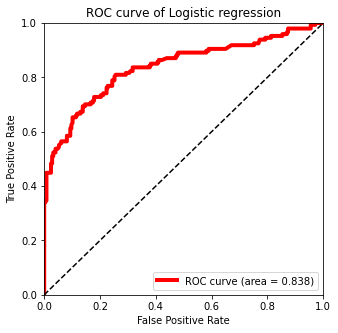

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산하여 출력
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc=roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" %roc_auc)

#ROC curve 그래프로 출력합니다.
plt.rcParams['figure.figsize']=[5,5]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' %roc_auc, color='red', linewidth=4.0)
plt.plot([0,1],[0,1],'k--')
plt.ylim([0.0,1.0])
plt.xlim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

#### - 의사결정나무 모델
#### : 피처 단위로 조건을 분기하여 정답의 집합을 좁혀나가는 방법

### < 의사결정 나무 >

In [60]:
from sklearn.tree import DecisionTreeClassifier

# 의사결정나무를 학습하고, 학습한 모델로 테스트 데이터셋에 대한 예측값을 반환
dtc=DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred=dtc.predict(x_test)
y_pred_probablity=dtc.predict_proba(x_test)[:,1]

# 학습한 모델의 성능을 계산하여 출력
print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1-Score : %.3f" % f1_score(y_test, y_pred))

Accuracy : 0.76
Precision : 0.688
Recall : 0.646
F1-Score : 0.667


In [61]:
# 학습한 모델의 AUC를 계산하여 출력합니다
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" %roc_auc)

AUC : 0.750


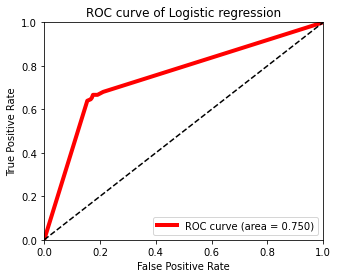

In [62]:
# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

## Step3. 모델개선 : 피처 엔지니어링 알고리즘
#### - 피처 엔지니어링 : 모델에 사용할 피처를 가공하는 분석작업
### < 분류 모델을 위해 전처리하기 >

In [174]:
df_train = pd.read_csv("data/titanic_train.csv")
df_test = pd.read_csv("data/titanic_test.csv")
df_train=df_train.drop(['ticket', 'body', 'home.dest'],axis=1)
df_test=df_test.drop(['ticket', 'body', 'home.dest'],axis=1)

In [176]:
replace_mean=df_train[df_train['age']>0]['age'].mean()
df_train['age']=df_train['age'].fillna(replace_mean)
df_test['age']=df_test['age'].fillna(replace_mean)

#embark : 2개의 결측값을 최빈값으로 대체합니다.
embarked_mode=df_train['embarked'].value_counts().index[0]
df_train['embarked']=df_train['embarked'].fillna(embarked_mode)
df_test['embarked']=df_test['embarked'].fillna(embarked_mode)

# 원 핫 코딩을 위한 통합데이터프레임(whole_df)를 생성
whole_df=df_train.append(df_test)
train_idx_num = len(df_train)

### < cabin 피처 활용하기 >

In [177]:
print(whole_df['cabin'].value_counts()[:10])

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C78                4
F2                 4
B96 B98            4
D                  4
F4                 4
F33                4
C22 C26            4
Name: cabin, dtype: int64


- 결측 데이터는 'X'로 대체
- cabin피처에서 첫번쨰 알파벳 추출해서 선실을 파악
- 데이터의 수가 적은 G,T 선실(cabin) 모두 'X'로 대체

In [178]:
# 결측 데이터의 경우 'X'로 대체합니다.
whole_df['cabin']=whole_df['cabin'].fillna('X')

# cabin피처에서 첫번쨰 알파벳 추출해서 선실을 파악합니다.
whole_df['cabin']=whole_df['cabin'].apply(lambda x: x[0])

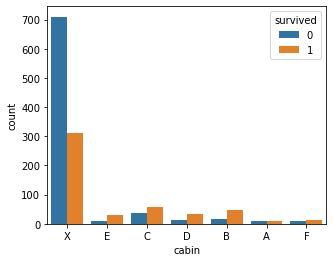

In [179]:
# 데이터의 수가 적은 G,T 선실(cabin) 모두 'X'로 대체합니다.
whole_df['cabin']=whole_df['cabin'].replace({"G":"X", "T":"X"})

ax=sns.countplot(x='cabin',hue='survived', data=whole_df)
plt.show()

### < name피처 활용하기 >
 - 당시 시대에는 사회적 계급이 존재하였기 때문에 호칭을 추출

In [180]:
# 이름에서 호칭을 추출
name_grade = whole_df['name'].apply(lambda x : x.split(",",1)[1].split(".")[0])
name_grade=name_grade.unique().tolist()
print(name_grade)

[' Miss', ' Mr', ' Master', ' Mrs', ' Dr', ' Mlle', ' Col', ' Rev', ' Ms', ' Mme', ' Sir', ' the Countess', ' Dona', ' Jonkheer', ' Lady', ' Major', ' Don', ' Capt']


In [181]:
# 호칭에 따라 사회적 지위(1910년대)를 정의
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직을 나타냅니다.
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성을 나타냅니다.
              'C': ['Jonkheer', 'the Countess'], # 귀족이나 작위를 나타냅니다.
              'D': ['Mr', 'Don'], # 남성을 나타냅니다.
              'E': ['Master'], # 젊은남성을 나타냅니다.
              'F': ['Miss', 'Mlle', 'Lady']} # 젊은 여성을 나타냅니다.

# 정의한 호칭의 기준에 따라 A~F 문자로 name 피처를 다시 정의
def give_grade(x):
    grade = x.split(", ",1)[1].split(".")[0]
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'


In [183]:
# 위의 함수를 적용하여 name 피처를 새롭게 정의
whole_df['name']=whole_df['name'].apply(lambda x: give_grade(x))
print(whole_df['name'].value_counts())


D    758
F    263
B    201
E     61
A     24
C      2
Name: name, dtype: int64


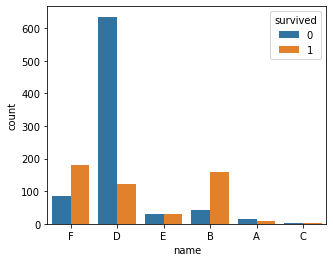

In [184]:
# 미니퀴즈 4-2 name피처에 대한 생존자/비생존자 그룹간의 차이
ax=sns.countplot(x='name',hue='survived', data=whole_df)
plt.show()

- 마지막 전처리 단계 : 모든 범주형 피처들에 원-핫 인코딩을 적용
### < 원-핫 인코딩>

In [185]:
# 판다스 패키지를 이용한 원-핫 인코당을 수행
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]
df_train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


accuracy: 0.79
Precision : 0.736
Recall : 0.701
F1 : 0.718
AUC : 0.853


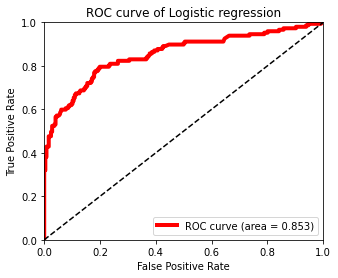

In [186]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합니다.
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

# 로지스틱 회귀 모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 학습한 모델의 테스트 데이터셋에 대한 예측 결과를 반환합니다.
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 테스트 데이터셋에 대한 accuracy, precision, recall, f1 평가 지표를 각각 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred)) # AUC (Area Under the Curve) & ROC curve

# AUC (Area Under the Curve)를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

### < 피처 영향력 살펴보기>
- 피치 엔지니어링 결과 : 'name', 'cabin'의 피처 영향력이 가장 크다

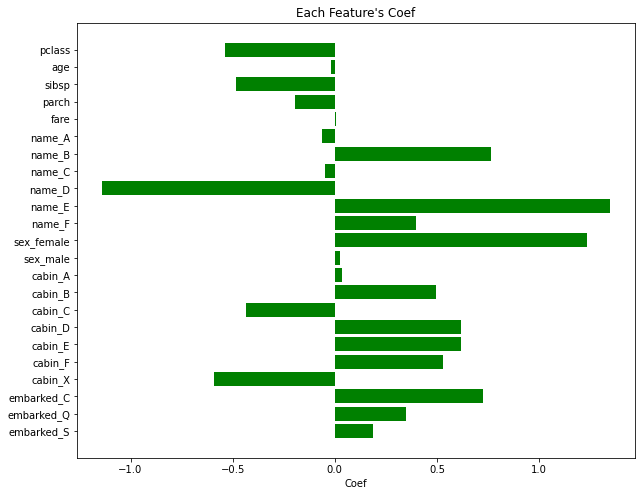

In [193]:
# 예측 대상인 survived 피처를 제외한 모든 피처를 리스트로 반환 (그래프의 y축)
cols=df_train.columns.tolist()
cols.remove('survived')
y_pos=np.arange(len(cols))


# 각 피처별 회귀 분석 계수를 그래프의 x축으로하여 피처 영향력 그래프를 출력합니다.
plt.rcParams['figure.figsize']=[10,8]
fig,ax=plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()

ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

## Step4. 평가 : 모델 검증하기

- 완성된 모델 검증 : 모델 과적합 여부 검증
  - 1. K-fold 교차 검증 : 학습용 데이터셋과 테스트용 데이터셋을 나눌때 불균등하게 나누어졌는지 검증
  - 2. 학습 곡선 : 학습데이터와 테스트데이터가 벌어져있는지 확인

### < K-fold 교차 검증 수행하기>
- sklearn.model_selection의 KFold 클래스로 cv라는 객체 반환
- 전체 데이터를 k개로 분리하여 학습과 평가를 반복
- k개로 분할된 fold중 k-1개를 데이터셋 1개를 테스트 데이터셋으로 지정
- 매 반복때마다 데이터셋은 변경됩니다.

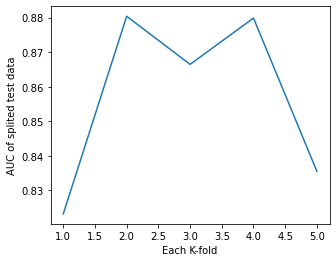

In [200]:
from sklearn.model_selection import KFold

# K-fold 교차 검증의 k를 5로 선정합니다.
k=5
cv=KFold(k,shuffle=True, random_state=0)
auc_history=[]

# K-fold를 5번의 학습으로 반복
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):
    # 5개로 분할된 fold중 4개를 데이터셋 1개를 테스트 데이터셋으로 지정
    # 매 반복때마다 데이터셋은 변경됩니다.
    df_train=whole_df_encoded.iloc[train_data_row]
    df_test=whole_df_encoded.iloc[test_data_row]
    
    # survived 피처를 y, 나머지 피처들을 x 데이터로 지정
    splited_x_train, splited_y_train = df_train.loc[:,df_train.columns!='survived'].values,df_train['survived'].values
    splited_x_test, splited_y_test = df_test.loc[:,df_test.columns!='survived'].values,df_test['survived'].values
    
    # 주어진 데이터로 로지스틱 회귀 모델을 학습합니다.
    lr=LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred=lr.predict(splited_x_test)
    y_pred_probability = lr.predict_proba(splited_x_test)[:,1]
    
    # 테스트 데이터셋의 AUC를 계산하여 auc_history에 저장
    false_positive_rate, true_positive_rate, thresholds = roc_curve(splited_y_test, y_pred_probability)
    roc_auc = roc_auc_score(splited_y_test, y_pred_probability)
    auc_history.append(roc_auc)
    
# auc_history에 저장된 다섯 번의 학습 결과(AUC)를 그래프로 출력합니다.
plt.rcParams['figure.figsize']=[5,4]
plt.xlabel("Each K-fold")
plt.ylabel("AUC of splited test data")
plt.plot(range(1,k+1),auc_history) # baseline

### < 학습 곡선 분석하기>

In [203]:
import scikitplot as skplt

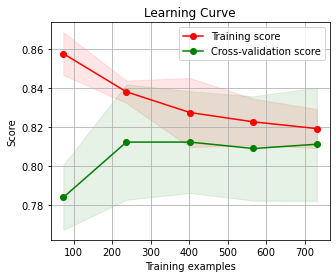

In [207]:
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()